# Causality Fundamentals: From Correlation to Causation

## Learning Objectives

By the end of this notebook, you will understand:

1. **Correlation vs Causation**
   - Why correlation doesn't imply causation
   - Simpson's paradox and confounding
   - The fundamental problem of causal inference

2. **Causal Graphs and DAGs**
   - Directed Acyclic Graphs (DAGs) for causality
   - d-separation and conditional independence
   - Identifying confounders, mediators, and colliders

3. **Causal Inference Methods**
   - Interventions and the do-operator
   - Backdoor and frontdoor adjustment
   - Propensity score matching
   - Instrumental variables

4. **Neural Networks for Causal Inference**
   - Representation learning for causal discovery
   - Treatment effect estimation with neural networks
   - Counterfactual reasoning
   - Causal regularization

**Prerequisites**: Basic probability, PyTorch fundamentals

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from typing import Callable, List, Tuple, Dict
import networkx as nx
from scipy import stats
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import pandas as pd

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


---

## Part 1: Correlation vs Causation

### 1.1 The Fundamental Problem

**Correlation**: Two variables X and Y are correlated if they tend to vary together.
- Measured by correlation coefficient: $\rho_{X,Y} = \frac{\text{Cov}(X,Y)}{\sigma_X \sigma_Y}$

**Causation**: X causes Y if changing X leads to a change in Y.
- Requires intervention: what happens if we force X to a particular value?

**Why they differ**: Correlation can arise from:
1. **X causes Y** (what we want)
2. **Y causes X** (reverse causation)
3. **Z causes both X and Y** (confounding)
4. **Pure coincidence** (spurious correlation)

### 1.2 Classic Examples of Spurious Correlation

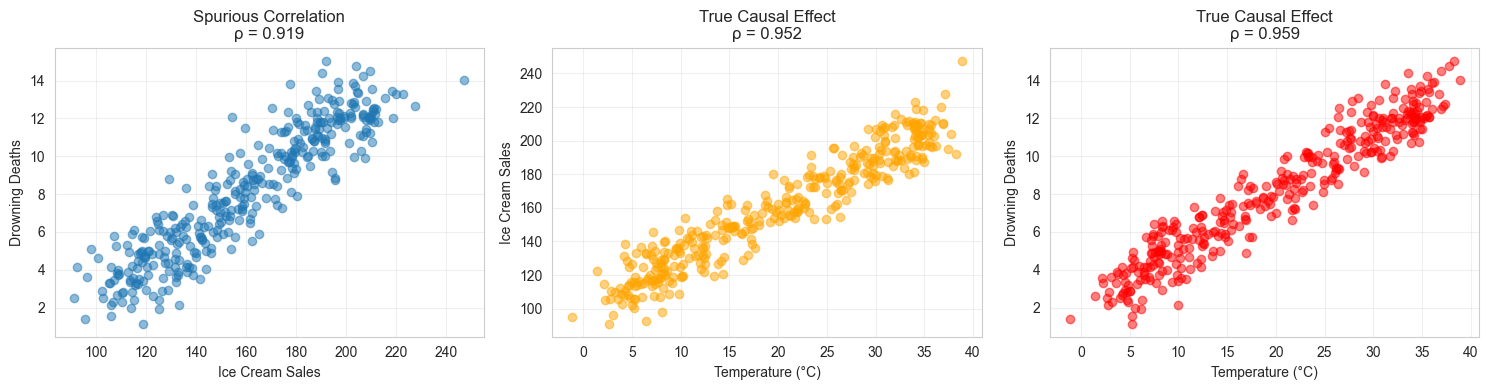

Key insight: Ice cream and drownings are correlated, but neither causes the other!
The confounder (temperature) causes both, creating a spurious correlation.


In [2]:
# Example 1: Ice cream sales and drowning deaths
# Hidden confounder: Temperature/Season

def generate_spurious_correlation_data(n_samples: int = 365) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Generate data where X and Y are correlated but not causally related."""
    # Days of the year
    days = np.arange(n_samples)
    
    # Temperature (confounder) - sinusoidal pattern
    temperature = 20 + 15 * np.sin(2 * np.pi * days / 365) + np.random.randn(n_samples) * 2
    
    # Ice cream sales (caused by temperature)
    ice_cream = 100 + 3 * temperature + np.random.randn(n_samples) * 10
    ice_cream = np.maximum(ice_cream, 0)  # Can't be negative
    
    # Drowning deaths (also caused by temperature)
    drownings = 2 + 0.3 * temperature + np.random.randn(n_samples) * 1
    drownings = np.maximum(drownings, 0)
    
    return ice_cream, drownings, temperature

ice_cream, drownings, temperature = generate_spurious_correlation_data()

# Compute correlations
corr_ice_drowning = np.corrcoef(ice_cream, drownings)[0, 1]
corr_temp_ice = np.corrcoef(temperature, ice_cream)[0, 1]
corr_temp_drowning = np.corrcoef(temperature, drownings)[0, 1]

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Ice cream vs drownings
axes[0].scatter(ice_cream, drownings, alpha=0.5)
axes[0].set_xlabel('Ice Cream Sales')
axes[0].set_ylabel('Drowning Deaths')
axes[0].set_title(f'Spurious Correlation\nρ = {corr_ice_drowning:.3f}')
axes[0].grid(True, alpha=0.3)

# Temperature vs ice cream
axes[1].scatter(temperature, ice_cream, alpha=0.5, color='orange')
axes[1].set_xlabel('Temperature (°C)')
axes[1].set_ylabel('Ice Cream Sales')
axes[1].set_title(f'True Causal Effect\nρ = {corr_temp_ice:.3f}')
axes[1].grid(True, alpha=0.3)

# Temperature vs drownings
axes[2].scatter(temperature, drownings, alpha=0.5, color='red')
axes[2].set_xlabel('Temperature (°C)')
axes[2].set_ylabel('Drowning Deaths')
axes[2].set_title(f'True Causal Effect\nρ = {corr_temp_drowning:.3f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key insight: Ice cream and drownings are correlated, but neither causes the other!")
print(f"The confounder (temperature) causes both, creating a spurious correlation.")

### 1.3 Simpson's Paradox

**Simpson's Paradox**: A trend that appears in different groups of data disappears or reverses when the groups are combined.

**Classic example**: Treatment effectiveness
- Overall: Treatment seems harmful
- Within each severity group: Treatment is beneficial
- Paradox: The overall conclusion is misleading!

**Why it happens**: Confounding by severity (sicker patients more likely to get treatment)

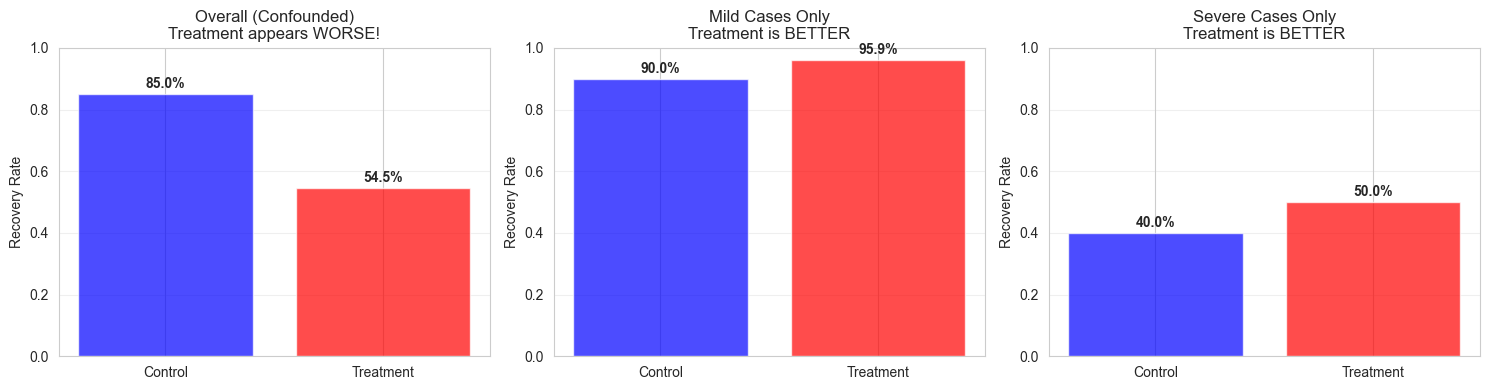


=== Simpson's Paradox ===
Overall: Treatment 54.5% vs Control 85.0% → Treatment appears 30.5% WORSE

But within each group:
Mild: Treatment 95.9% vs Control 90.0% → Treatment is 5.9% BETTER
Severe: Treatment 50.0% vs Control 40.0% → Treatment is 10.0% BETTER

Conclusion: Must control for confounders (severity) to get the true effect!


In [5]:
def generate_simpsons_paradox_data(n_samples: int = 1000) -> pd.DataFrame:
    """Generate data demonstrating Simpson's paradox."""
    
    data = []
    
    # Group 1: Mild cases
    # Most don't get treatment (90%), high recovery rate overall
    n_mild = n_samples // 2
    n_mild_treated = int(n_mild * 0.1)
    n_mild_control = n_mild - n_mild_treated
    
    # Mild + treated: 95% recovery
    data.extend([{'severity': 'mild', 'treatment': 1, 'recovery': 1}] * int(n_mild_treated * 0.95))
    data.extend([{'severity': 'mild', 'treatment': 1, 'recovery': 0}] * int(n_mild_treated * 0.05))
    
    # Mild + control: 90% recovery
    data.extend([{'severity': 'mild', 'treatment': 0, 'recovery': 1}] * int(n_mild_control * 0.90))
    data.extend([{'severity': 'mild', 'treatment': 0, 'recovery': 0}] * int(n_mild_control * 0.10))
    
    # Group 2: Severe cases
    # Most get treatment (90%), low recovery rate overall
    n_severe = n_samples // 2
    n_severe_treated = int(n_severe * 0.9)
    n_severe_control = n_severe - n_severe_treated
    
    # Severe + treated: 50% recovery
    data.extend([{'severity': 'severe', 'treatment': 1, 'recovery': 1}] * int(n_severe_treated * 0.50))
    data.extend([{'severity': 'severe', 'treatment': 1, 'recovery': 0}] * int(n_severe_treated * 0.50))
    
    # Severe + control: 40% recovery
    data.extend([{'severity': 'severe', 'treatment': 0, 'recovery': 1}] * int(n_severe_control * 0.40))
    data.extend([{'severity': 'severe', 'treatment': 0, 'recovery': 0}] * int(n_severe_control * 0.60))
    
    return pd.DataFrame(data)

df = generate_simpsons_paradox_data(1000)

# Overall statistics
overall_treated = df[df['treatment'] == 1]['recovery'].mean()
overall_control = df[df['treatment'] == 0]['recovery'].mean()

# By severity
mild_treated = df[(df['severity'] == 'mild') & (df['treatment'] == 1)]['recovery'].mean()
mild_control = df[(df['severity'] == 'mild') & (df['treatment'] == 0)]['recovery'].mean()
severe_treated = df[(df['severity'] == 'severe') & (df['treatment'] == 1)]['recovery'].mean()
severe_control = df[(df['severity'] == 'severe') & (df['treatment'] == 0)]['recovery'].mean()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall (misleading)
axes[0].bar(['Control', 'Treatment'], [overall_control, overall_treated], 
            color=['blue', 'red'], alpha=0.7)
axes[0].set_ylabel('Recovery Rate')
axes[0].set_title('Overall (Confounded)\nTreatment appears WORSE!')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([overall_control, overall_treated], ['Control', 'Treatment'])):
    axes[0].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

# Mild cases
axes[1].bar(['Control', 'Treatment'], [mild_control, mild_treated], 
            color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Recovery Rate')
axes[1].set_title('Mild Cases Only\nTreatment is BETTER')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([mild_control, mild_treated], ['Control', 'Treatment'])):
    axes[1].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

# Severe cases
axes[2].bar(['Control', 'Treatment'], [severe_control, severe_treated], 
            color=['blue', 'red'], alpha=0.7)
axes[2].set_ylabel('Recovery Rate')
axes[2].set_title('Severe Cases Only\nTreatment is BETTER')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([severe_control, severe_treated], ['Control', 'Treatment'])):
    axes[2].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Simpson's Paradox ===")
print(f"Overall: Treatment {overall_treated:.1%} vs Control {overall_control:.1%} "
      f"→ Treatment appears {abs(overall_treated - overall_control):.1%} WORSE")
print(f"\nBut within each group:")
print(f"Mild: Treatment {mild_treated:.1%} vs Control {mild_control:.1%} "
      f"→ Treatment is {mild_treated - mild_control:.1%} BETTER")
print(f"Severe: Treatment {severe_treated:.1%} vs Control {severe_control:.1%} "
      f"→ Treatment is {severe_treated - severe_control:.1%} BETTER")
print(f"\nConclusion: Must control for confounders (severity) to get the true effect!")

---

## Part 2: Causal Graphs and DAGs

### 2.1 Directed Acyclic Graphs (DAGs)

**DAG**: A graph with directed edges (arrows) and no cycles.
- Nodes: Variables
- Edges: Direct causal relationships
- Arrow from X → Y means "X directly causes Y"

**Key structures**:
1. **Chain**: X → Z → Y (Z is a mediator)
2. **Fork**: X ← Z → Y (Z is a confounder)
3. **Collider**: X → Z ← Y (Z is a collider)

### 2.2 d-Separation and Conditional Independence

**d-separation** (directional separation): A criterion for determining conditional independence from a DAG.

**Rules**: X and Y are d-separated given Z if all paths between X and Y are blocked:
1. **Chain** (X → Z → Y): Blocked by conditioning on Z
2. **Fork** (X ← Z → Y): Blocked by conditioning on Z
3. **Collider** (X → Z ← Y): Blocked by NOT conditioning on Z (blocked by default!)

**Why colliders are special**: Conditioning on a collider creates a spurious association!

=== Structure 1: Chain (Mediator) ===
X → Z → Y
Z is a mediator: X affects Y through Z
Conditioning on Z blocks the path: X ⊥ Y | Z


/tmp/ipykernel_32682/2467357348.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


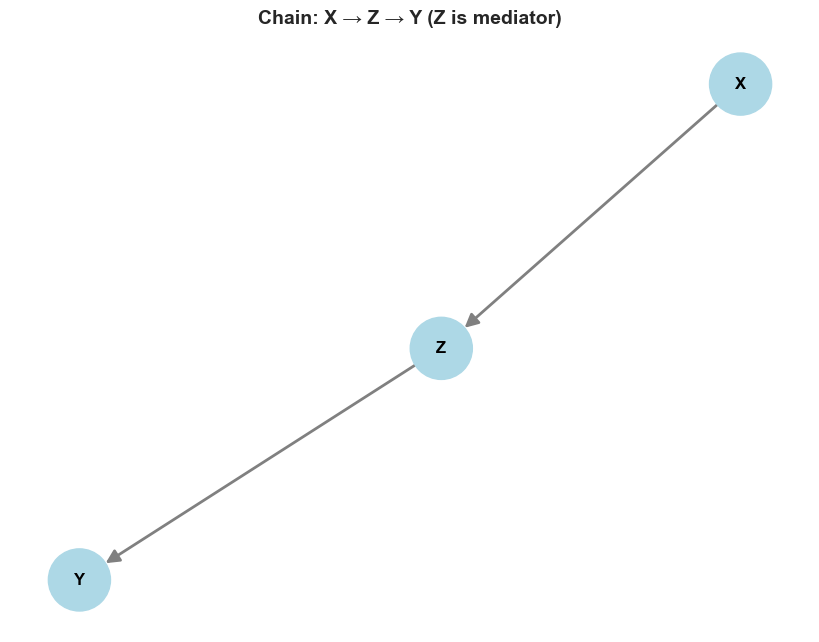

Correlation X-Y (unconditional): 0.967 (significant)
Correlation X-Y (conditional on Z): -0.020 (near zero!)


=== Structure 2: Fork (Confounder) ===
X ← Z → Y
Z is a confounder: Z causes both X and Y
Conditioning on Z blocks the path: X ⊥ Y | Z


/tmp/ipykernel_32682/2467357348.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


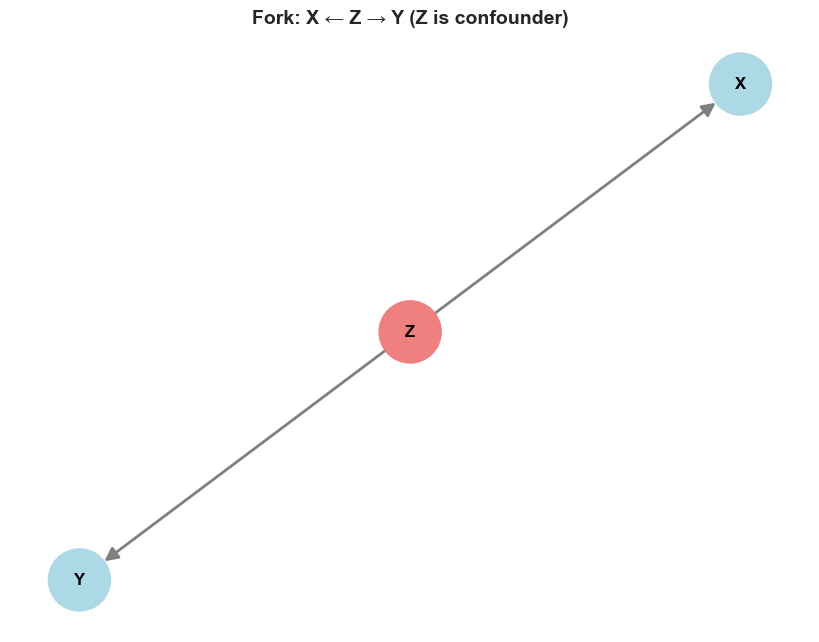

Correlation X-Y (unconditional): 0.957 (significant - spurious!)
Correlation X-Y (conditional on Z): -0.011 (near zero!)


=== Structure 3: Collider ===
X → Z ← Y
Z is a collider: both X and Y cause Z
CAREFUL: X and Y are independent, but conditioning on Z creates spurious correlation!


/tmp/ipykernel_32682/2467357348.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


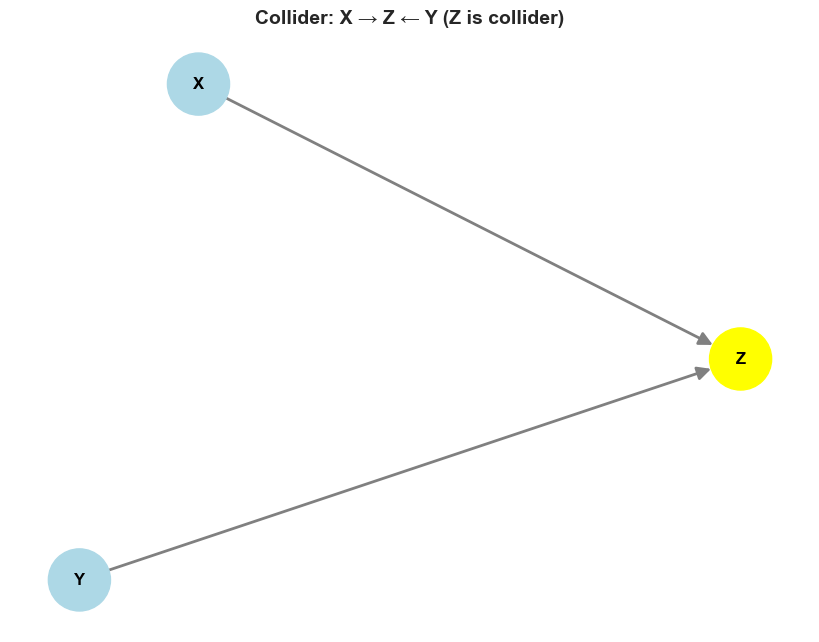

Correlation X-Y (unconditional): 0.005 (near zero - independent!)
Correlation X-Y (conditional on Z): -0.797 (significant!)

⚠️ Conditioning on a collider CREATES spurious correlation (collider bias)!


In [6]:
def plot_dag(edges: List[Tuple[str, str]], title: str, node_colors: Dict[str, str] = None):
    """Plot a directed acyclic graph."""
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G, seed=42)
    
    # Default colors
    if node_colors is None:
        node_colors = {node: 'lightblue' for node in G.nodes()}
    
    colors = [node_colors.get(node, 'lightblue') for node in G.nodes()]
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, 
            font_size=12, font_weight='bold', arrows=True, 
            arrowsize=20, edge_color='gray', width=2)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example 1: Chain (Mediator)
print("=== Structure 1: Chain (Mediator) ===")
print("X → Z → Y")
print("Z is a mediator: X affects Y through Z")
print("Conditioning on Z blocks the path: X ⊥ Y | Z")
plot_dag([('X', 'Z'), ('Z', 'Y')], 'Chain: X → Z → Y (Z is mediator)')

# Demonstrate with data
n = 10000
X = np.random.randn(n)
Z = 2 * X + np.random.randn(n) * 0.5  # Z caused by X
Y = 3 * Z + np.random.randn(n) * 0.5  # Y caused by Z

print(f"Correlation X-Y (unconditional): {np.corrcoef(X, Y)[0,1]:.3f} (significant)")

# Condition on Z by regression
from sklearn.linear_model import LinearRegression
reg_x = LinearRegression().fit(Z.reshape(-1, 1), X)
X_residual = X - reg_x.predict(Z.reshape(-1, 1))
reg_y = LinearRegression().fit(Z.reshape(-1, 1), Y)
Y_residual = Y - reg_y.predict(Z.reshape(-1, 1))

print(f"Correlation X-Y (conditional on Z): {np.corrcoef(X_residual, Y_residual)[0,1]:.3f} (near zero!)\n")

# Example 2: Fork (Confounder)
print("\n=== Structure 2: Fork (Confounder) ===")
print("X ← Z → Y")
print("Z is a confounder: Z causes both X and Y")
print("Conditioning on Z blocks the path: X ⊥ Y | Z")
plot_dag([('Z', 'X'), ('Z', 'Y')], 'Fork: X ← Z → Y (Z is confounder)', 
         node_colors={'Z': 'lightcoral', 'X': 'lightblue', 'Y': 'lightblue'})

# Demonstrate
Z = np.random.randn(n)
X = 2 * Z + np.random.randn(n) * 0.5
Y = 3 * Z + np.random.randn(n) * 0.5

print(f"Correlation X-Y (unconditional): {np.corrcoef(X, Y)[0,1]:.3f} (significant - spurious!)")

# Condition on Z
reg_x = LinearRegression().fit(Z.reshape(-1, 1), X)
X_residual = X - reg_x.predict(Z.reshape(-1, 1))
reg_y = LinearRegression().fit(Z.reshape(-1, 1), Y)
Y_residual = Y - reg_y.predict(Z.reshape(-1, 1))

print(f"Correlation X-Y (conditional on Z): {np.corrcoef(X_residual, Y_residual)[0,1]:.3f} (near zero!)\n")

# Example 3: Collider
print("\n=== Structure 3: Collider ===")
print("X → Z ← Y")
print("Z is a collider: both X and Y cause Z")
print("CAREFUL: X and Y are independent, but conditioning on Z creates spurious correlation!")
plot_dag([('X', 'Z'), ('Y', 'Z')], 'Collider: X → Z ← Y (Z is collider)',
         node_colors={'Z': 'yellow', 'X': 'lightblue', 'Y': 'lightblue'})

# Demonstrate
X = np.random.randn(n)
Y = np.random.randn(n)  # X and Y are independent!
Z = X + Y + np.random.randn(n) * 0.5  # Z is caused by both

print(f"Correlation X-Y (unconditional): {np.corrcoef(X, Y)[0,1]:.3f} (near zero - independent!)")

# Condition on Z
reg_x = LinearRegression().fit(Z.reshape(-1, 1), X)
X_residual = X - reg_x.predict(Z.reshape(-1, 1))
reg_y = LinearRegression().fit(Z.reshape(-1, 1), Y)
Y_residual = Y - reg_y.predict(Z.reshape(-1, 1))

print(f"Correlation X-Y (conditional on Z): {np.corrcoef(X_residual, Y_residual)[0,1]:.3f} (significant!)")
print("\n⚠️ Conditioning on a collider CREATES spurious correlation (collider bias)!")

### 2.3 Real-World Example: Berkeley Admissions Paradox

**Context**: Berkeley was sued in 1973 for gender bias in admissions.
- Overall: Men had higher admission rate than women
- Within each department: Women had equal or higher admission rates

**Causal structure**:
- Gender → Department choice
- Department choice → Admission
- Department is a **collider** (caused by gender) and a **confounder** (causes admission)

**Lesson**: Need to understand causal structure to correctly adjust for confounding!

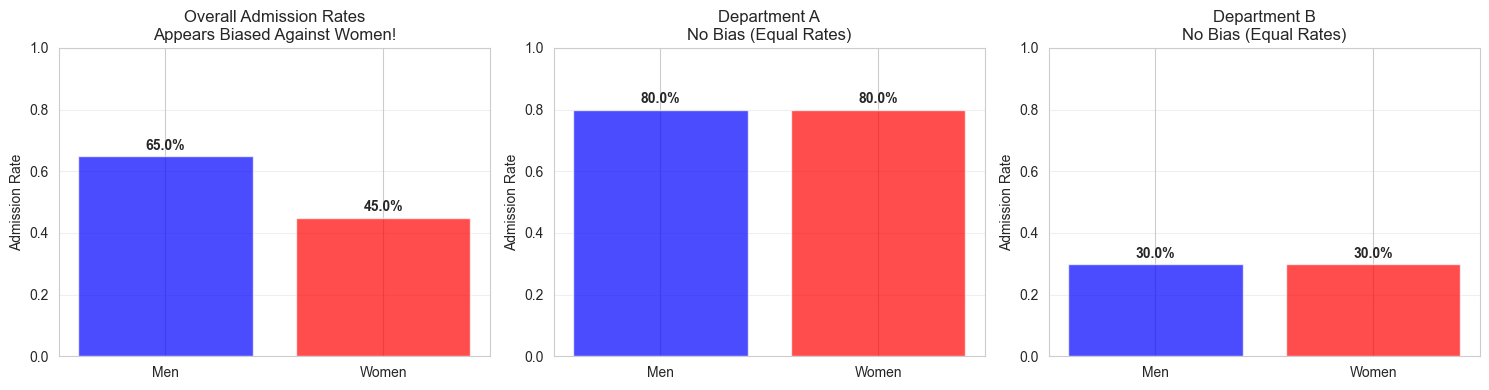

=== Berkeley Admissions Paradox ===
Overall: Men 65.0%, Women 45.0% → Appears biased!

But within departments:
Dept A: Men 80.0%, Women 80.0% → No bias
Dept B: Men 30.0%, Women 30.0% → No bias

Explanation: Men apply more to easy departments (A), women to hard ones (B)
Department is a confounder that must be controlled for!


/tmp/ipykernel_32682/2467357348.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


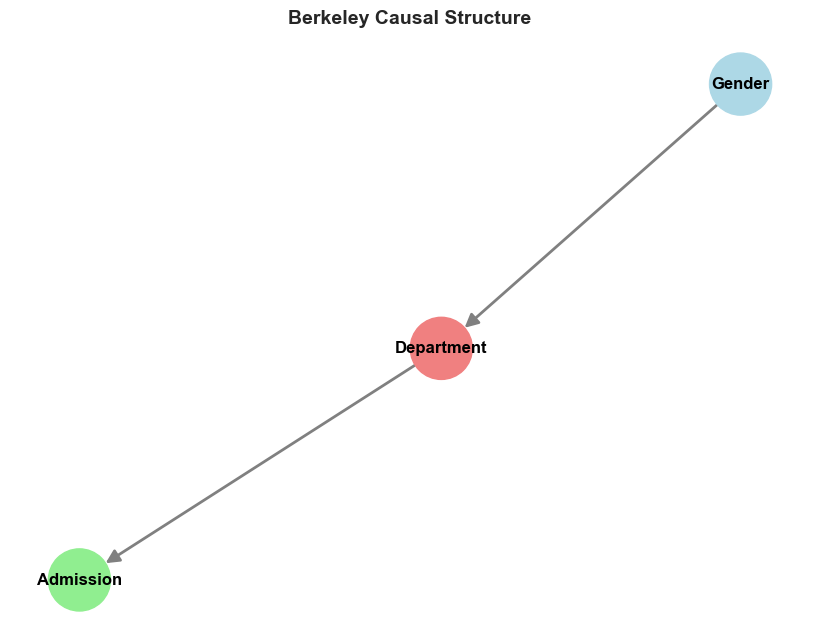

In [7]:
# Simulate Berkeley admissions data
def simulate_berkeley_data(n_applicants: int = 10000):
    data = []
    
    # Department A: Easy to get in, attracts more men
    # 70% men apply, 80% admission rate for all
    n_dept_a = n_applicants // 2
    n_men_a = int(n_dept_a * 0.7)
    n_women_a = n_dept_a - n_men_a
    
    data.extend([{'gender': 'M', 'dept': 'A', 'admitted': 1}] * int(n_men_a * 0.80))
    data.extend([{'gender': 'M', 'dept': 'A', 'admitted': 0}] * int(n_men_a * 0.20))
    data.extend([{'gender': 'F', 'dept': 'A', 'admitted': 1}] * int(n_women_a * 0.80))
    data.extend([{'gender': 'F', 'dept': 'A', 'admitted': 0}] * int(n_women_a * 0.20))
    
    # Department B: Hard to get in, attracts more women
    # 30% men apply, 30% admission rate for all
    n_dept_b = n_applicants // 2
    n_men_b = int(n_dept_b * 0.3)
    n_women_b = n_dept_b - n_men_b
    
    data.extend([{'gender': 'M', 'dept': 'B', 'admitted': 1}] * int(n_men_b * 0.30))
    data.extend([{'gender': 'M', 'dept': 'B', 'admitted': 0}] * int(n_men_b * 0.70))
    data.extend([{'gender': 'F', 'dept': 'B', 'admitted': 1}] * int(n_women_b * 0.30))
    data.extend([{'gender': 'F', 'dept': 'B', 'admitted': 0}] * int(n_women_b * 0.70))
    
    return pd.DataFrame(data)

df_berkeley = simulate_berkeley_data(10000)

# Overall admission rates
men_overall = df_berkeley[df_berkeley['gender'] == 'M']['admitted'].mean()
women_overall = df_berkeley[df_berkeley['gender'] == 'F']['admitted'].mean()

# By department
men_a = df_berkeley[(df_berkeley['gender'] == 'M') & (df_berkeley['dept'] == 'A')]['admitted'].mean()
women_a = df_berkeley[(df_berkeley['gender'] == 'F') & (df_berkeley['dept'] == 'A')]['admitted'].mean()
men_b = df_berkeley[(df_berkeley['gender'] == 'M') & (df_berkeley['dept'] == 'B')]['admitted'].mean()
women_b = df_berkeley[(df_berkeley['gender'] == 'F') & (df_berkeley['dept'] == 'B')]['admitted'].mean()

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Overall
axes[0].bar(['Men', 'Women'], [men_overall, women_overall], 
            color=['blue', 'red'], alpha=0.7)
axes[0].set_ylabel('Admission Rate')
axes[0].set_title('Overall Admission Rates\nAppears Biased Against Women!')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([men_overall, women_overall], ['Men', 'Women'])):
    axes[0].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

# Department A
axes[1].bar(['Men', 'Women'], [men_a, women_a], 
            color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Admission Rate')
axes[1].set_title('Department A\nNo Bias (Equal Rates)')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([men_a, women_a], ['Men', 'Women'])):
    axes[1].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

# Department B
axes[2].bar(['Men', 'Women'], [men_b, women_b], 
            color=['blue', 'red'], alpha=0.7)
axes[2].set_ylabel('Admission Rate')
axes[2].set_title('Department B\nNo Bias (Equal Rates)')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, (val, label) in enumerate(zip([men_b, women_b], ['Men', 'Women'])):
    axes[2].text(i, val + 0.02, f'{val:.1%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("=== Berkeley Admissions Paradox ===")
print(f"Overall: Men {men_overall:.1%}, Women {women_overall:.1%} → Appears biased!")
print(f"\nBut within departments:")
print(f"Dept A: Men {men_a:.1%}, Women {women_a:.1%} → No bias")
print(f"Dept B: Men {men_b:.1%}, Women {women_b:.1%} → No bias")
print(f"\nExplanation: Men apply more to easy departments (A), women to hard ones (B)")
print(f"Department is a confounder that must be controlled for!")

# Show causal graph
plot_dag([('Gender', 'Department'), ('Department', 'Admission')],
         'Berkeley Causal Structure',
         node_colors={'Gender': 'lightblue', 'Department': 'lightcoral', 'Admission': 'lightgreen'})

---

## Part 3: Causal Inference Methods

### 3.1 The do-Operator and Interventions

**Observation** P(Y|X=x): Seeing X=x occur naturally
- "What is Y when we observe X=x?"
- Includes all confounding

**Intervention** P(Y|do(X=x)): Forcing X=x by external intervention
- "What is Y when we set X=x?"
- Removes confounding

**Example**:
- P(recovery|took medicine) includes selection bias (sicker people take medicine)
- P(recovery|do(take medicine)) is the true causal effect

**Computing do-probabilities**:
1. **Randomized Controlled Trial (RCT)**: Force random assignment → gold standard
2. **Backdoor adjustment**: Control for confounders
3. **Frontdoor adjustment**: Use mediators when confounders unobserved
4. **Instrumental variables**: Use natural experiments

### 3.2 Backdoor Adjustment

**Backdoor criterion**: A set Z satisfies the backdoor criterion if:
1. Z blocks all backdoor paths from X to Y
2. Z contains no descendants of X

**Adjustment formula**:
$$P(Y|do(X=x)) = \sum_z P(Y|X=x, Z=z) P(Z=z)$$

**Intuition**: Stratify by confounder Z, compute effect within each stratum, then average.

=== Causal Effect Estimation ===
True causal effect (by construction): 2.0
Naive estimate (confounded): -0.477
Backdoor adjustment estimate: 1.878

Backdoor adjustment recovers the true effect by controlling for Z!


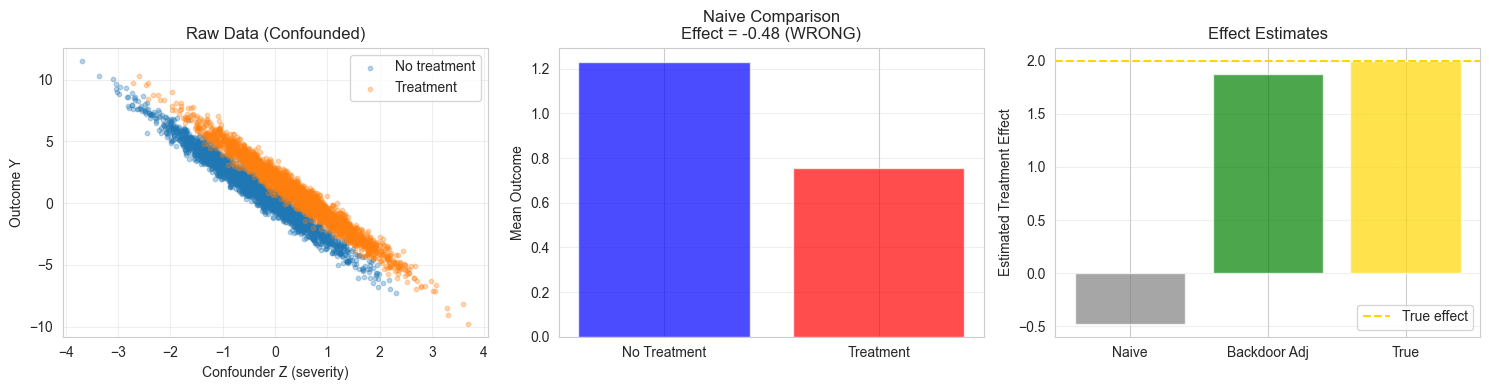

In [8]:
def simulate_confounded_treatment_data(n: int = 5000) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate treatment effect with confounding.
    
    Causal structure: Z → X, Z → Y, X → Y
    - Z: Confounder (e.g., disease severity)
    - X: Treatment
    - Y: Outcome
    
    True causal effect: X causes Y with coefficient 2.0
    """
    # Confounder (e.g., severity)
    Z = np.random.randn(n)
    
    # Treatment (influenced by severity - sicker patients more likely to get treatment)
    treatment_prob = 1 / (1 + np.exp(-Z))  # Logistic
    X = (np.random.rand(n) < treatment_prob).astype(float)
    
    # Outcome (influenced by both severity and treatment)
    Y = -3 * Z + 2 * X + np.random.randn(n) * 0.5  # True effect of X on Y is +2
    
    return X, Y, Z

X, Y, Z = simulate_confounded_treatment_data(5000)

# Naive estimate (confounded)
naive_effect = Y[X == 1].mean() - Y[X == 0].mean()

# Backdoor adjustment (stratify by Z)
# Discretize Z into bins
z_bins = pd.cut(Z, bins=10, labels=False)

adjusted_effects = []
weights = []

for bin_idx in range(10):
    mask = z_bins == bin_idx
    if mask.sum() > 0 and (X[mask] == 1).sum() > 0 and (X[mask] == 0).sum() > 0:
        # Effect within this stratum
        effect = Y[mask & (X == 1)].mean() - Y[mask & (X == 0)].mean()
        adjusted_effects.append(effect)
        weights.append(mask.sum())

# Weighted average
backdoor_effect = np.average(adjusted_effects, weights=weights)

print("=== Causal Effect Estimation ===")
print(f"True causal effect (by construction): 2.0")
print(f"Naive estimate (confounded): {naive_effect:.3f}")
print(f"Backdoor adjustment estimate: {backdoor_effect:.3f}")
print(f"\nBackdoor adjustment recovers the true effect by controlling for Z!")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Confounding visualization
axes[0].scatter(Z[X == 0], Y[X == 0], alpha=0.3, label='No treatment', s=10)
axes[0].scatter(Z[X == 1], Y[X == 1], alpha=0.3, label='Treatment', s=10)
axes[0].set_xlabel('Confounder Z (severity)')
axes[0].set_ylabel('Outcome Y')
axes[0].set_title('Raw Data (Confounded)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Naive comparison
axes[1].bar(['No Treatment', 'Treatment'], 
            [Y[X == 0].mean(), Y[X == 1].mean()],
            color=['blue', 'red'], alpha=0.7)
axes[1].set_ylabel('Mean Outcome')
axes[1].set_title(f'Naive Comparison\nEffect = {naive_effect:.2f} (WRONG)')
axes[1].grid(True, alpha=0.3, axis='y')

# Adjusted comparison
axes[2].bar(['Naive', 'Backdoor Adj', 'True'], 
            [naive_effect, backdoor_effect, 2.0],
            color=['gray', 'green', 'gold'], alpha=0.7)
axes[2].axhline(y=2.0, color='gold', linestyle='--', label='True effect')
axes[2].set_ylabel('Estimated Treatment Effect')
axes[2].set_title('Effect Estimates')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].legend()

plt.tight_layout()
plt.show()

### 3.3 Propensity Score Matching

**Problem**: When there are many confounders, stratification becomes infeasible (curse of dimensionality).

**Solution**: Propensity score matching
- **Propensity score**: e(Z) = P(X=1|Z) (probability of receiving treatment given confounders)
- **Key theorem** (Rosenbaum & Rubin, 1983): Conditioning on e(Z) is sufficient for removing confounding

**Method**:
1. Estimate propensity scores e(Z) using logistic regression
2. Match treated units to control units with similar propensity scores
3. Estimate effect within matched pairs

=== Propensity Score Matching (Multiple Confounders) ===
True causal effect: 3.0
Naive estimate: 1.456
Propensity score matching: 2.979

PSM successfully adjusts for high-dimensional confounding!


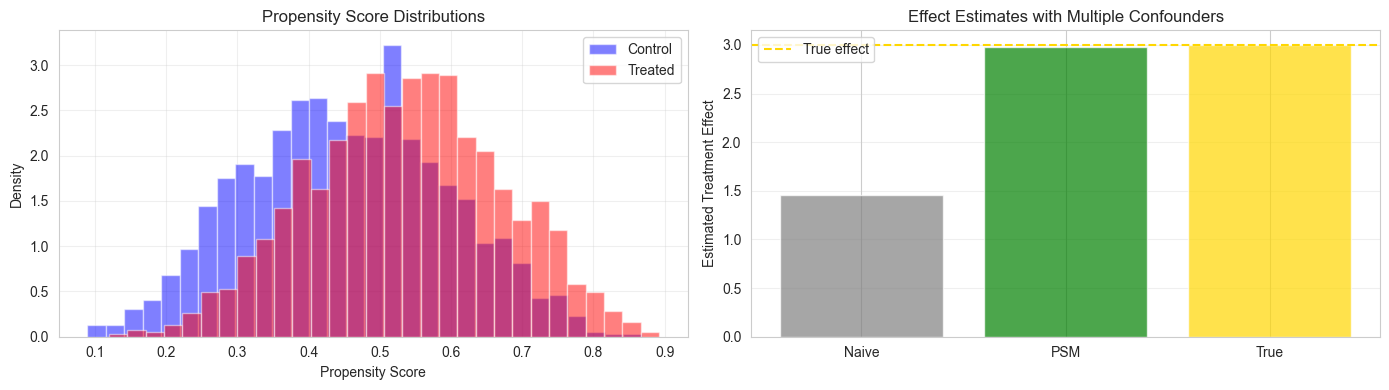

In [9]:
def propensity_score_matching(X: np.ndarray, Y: np.ndarray, Z: np.ndarray) -> float:
    """
    Estimate treatment effect using propensity score matching.
    
    Args:
        X: Treatment (0/1)
        Y: Outcome
        Z: Confounders (can be multidimensional)
    
    Returns:
        Estimated average treatment effect
    """
    # Ensure Z is 2D
    if Z.ndim == 1:
        Z = Z.reshape(-1, 1)
    
    # Step 1: Estimate propensity scores
    propensity_model = LogisticRegression()
    propensity_model.fit(Z, X)
    propensity_scores = propensity_model.predict_proba(Z)[:, 1]
    
    # Step 2: Match each treated unit to nearest control unit
    treated_idx = np.where(X == 1)[0]
    control_idx = np.where(X == 0)[0]
    
    matched_effects = []
    
    for t_idx in treated_idx:
        # Find control unit with closest propensity score
        ps_t = propensity_scores[t_idx]
        ps_controls = propensity_scores[control_idx]
        
        closest_control = control_idx[np.argmin(np.abs(ps_controls - ps_t))]
        
        # Compute effect for this matched pair
        effect = Y[t_idx] - Y[closest_control]
        matched_effects.append(effect)
    
    # Step 3: Average over matched pairs
    return np.mean(matched_effects), propensity_scores

# Generate data with multiple confounders
n = 3000
Z1 = np.random.randn(n)
Z2 = np.random.randn(n)
Z3 = np.random.randn(n)
Z_multi = np.column_stack([Z1, Z2, Z3])

# Treatment depends on all confounders
treatment_logit = 0.5 * Z1 + 0.3 * Z2 + 0.2 * Z3
treatment_prob = 1 / (1 + np.exp(-treatment_logit))
X_multi = (np.random.rand(n) < treatment_prob).astype(float)

# Outcome depends on all confounders + treatment
Y_multi = -2 * Z1 - 1.5 * Z2 - 1 * Z3 + 3 * X_multi + np.random.randn(n) * 0.5

# Estimate effects
naive_effect_multi = Y_multi[X_multi == 1].mean() - Y_multi[X_multi == 0].mean()
psm_effect, propensity_scores = propensity_score_matching(X_multi, Y_multi, Z_multi)

print("=== Propensity Score Matching (Multiple Confounders) ===")
print(f"True causal effect: 3.0")
print(f"Naive estimate: {naive_effect_multi:.3f}")
print(f"Propensity score matching: {psm_effect:.3f}")
print(f"\nPSM successfully adjusts for high-dimensional confounding!")

# Visualize propensity score overlap
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Propensity score distributions
axes[0].hist(propensity_scores[X_multi == 0], bins=30, alpha=0.5, 
             label='Control', density=True, color='blue')
axes[0].hist(propensity_scores[X_multi == 1], bins=30, alpha=0.5, 
             label='Treated', density=True, color='red')
axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Propensity Score Distributions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Effect estimates
axes[1].bar(['Naive', 'PSM', 'True'], 
            [naive_effect_multi, psm_effect, 3.0],
            color=['gray', 'green', 'gold'], alpha=0.7)
axes[1].axhline(y=3.0, color='gold', linestyle='--', label='True effect')
axes[1].set_ylabel('Estimated Treatment Effect')
axes[1].set_title('Effect Estimates with Multiple Confounders')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.4 Instrumental Variables

**Problem**: Unmeasured confounding (confounder U is unobserved)
- Structure: U → X, U → Y, X → Y
- Cannot use backdoor adjustment (U is unmeasured)

**Solution**: Instrumental variable (IV)
- Z is an instrument if:
  1. Z affects X (relevance)
  2. Z affects Y only through X (exclusion restriction)
  3. Z is independent of U (no confounding)

**Examples**:
- Effect of education on earnings: Use geographic proximity to college as IV
- Effect of military service on earnings: Use draft lottery number as IV

**Estimation**: Two-stage least squares (2SLS)
1. Stage 1: Regress X on Z to get predicted X̂
2. Stage 2: Regress Y on X̂

=== Instrumental Variables (Unmeasured Confounding) ===
True causal effect: 1.5
Naive OLS (confounded): 2.356
2SLS with instrument: 1.532

IV successfully recovers causal effect even with unmeasured confounding!


/tmp/ipykernel_32682/2467357348.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


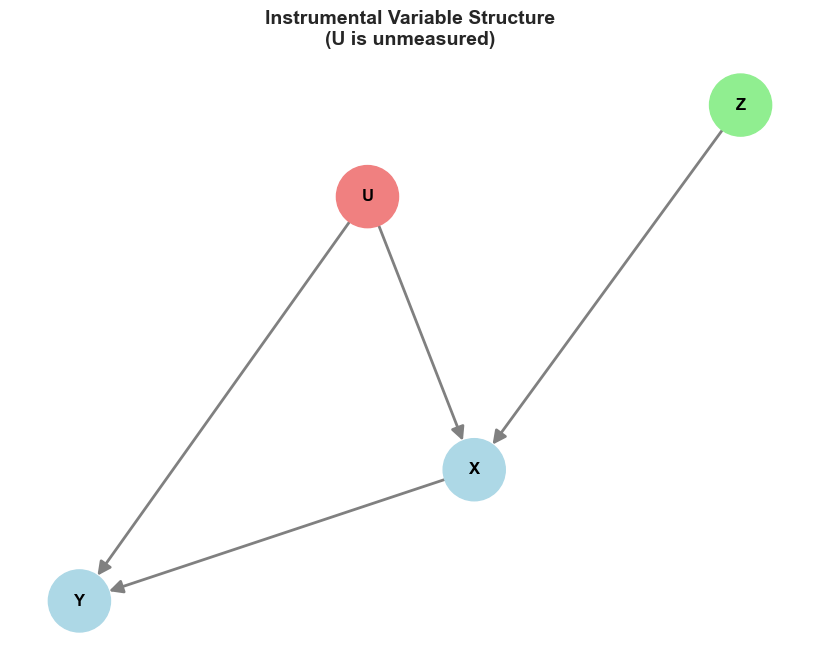

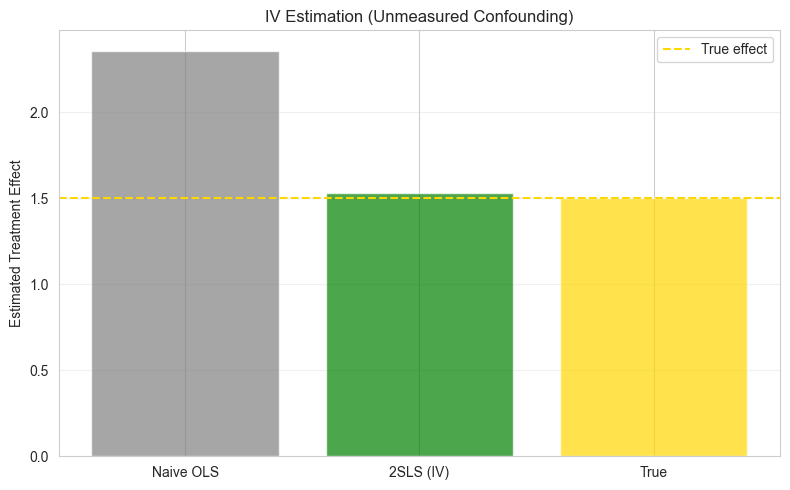

In [10]:
def two_stage_least_squares(Z: np.ndarray, X: np.ndarray, Y: np.ndarray) -> float:
    """
    Estimate causal effect using instrumental variables (2SLS).
    
    Args:
        Z: Instrument
        X: Treatment (potentially confounded)
        Y: Outcome
    
    Returns:
        Estimated causal effect of X on Y
    """
    from sklearn.linear_model import LinearRegression
    
    # Stage 1: Regress X on Z
    stage1 = LinearRegression()
    stage1.fit(Z.reshape(-1, 1), X)
    X_predicted = stage1.predict(Z.reshape(-1, 1))
    
    # Stage 2: Regress Y on predicted X
    stage2 = LinearRegression()
    stage2.fit(X_predicted.reshape(-1, 1), Y)
    
    return stage2.coef_[0]

# Simulate IV data
n = 5000

# Unmeasured confounder
U = np.random.randn(n)

# Instrument (e.g., randomized encouragement)
Z_iv = np.random.randn(n)

# Treatment (affected by both instrument and confounder)
X_iv = 2 * Z_iv + 3 * U + np.random.randn(n)

# Outcome (affected by treatment and confounder)
Y_iv = 1.5 * X_iv + 4 * U + np.random.randn(n)
# True effect of X on Y is 1.5

# Naive OLS (confounded)
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_iv.reshape(-1, 1), Y_iv)
naive_iv_effect = ols.coef_[0]

# 2SLS with instrument
iv_effect = two_stage_least_squares(Z_iv, X_iv, Y_iv)

print("=== Instrumental Variables (Unmeasured Confounding) ===")
print(f"True causal effect: 1.5")
print(f"Naive OLS (confounded): {naive_iv_effect:.3f}")
print(f"2SLS with instrument: {iv_effect:.3f}")
print(f"\nIV successfully recovers causal effect even with unmeasured confounding!")

# Visualize causal structure
plot_dag([('U', 'X'), ('U', 'Y'), ('X', 'Y'), ('Z', 'X')],
         'Instrumental Variable Structure\n(U is unmeasured)',
         node_colors={'Z': 'lightgreen', 'X': 'lightblue', 'Y': 'lightblue', 'U': 'lightcoral'})

# Show effect estimates
plt.figure(figsize=(8, 5))
plt.bar(['Naive OLS', '2SLS (IV)', 'True'], 
        [naive_iv_effect, iv_effect, 1.5],
        color=['gray', 'green', 'gold'], alpha=0.7)
plt.axhline(y=1.5, color='gold', linestyle='--', label='True effect')
plt.ylabel('Estimated Treatment Effect')
plt.title('IV Estimation (Unmeasured Confounding)')
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.show()

---

## Part 4: Neural Networks for Causal Inference

### 4.1 Treatment Effect Estimation with Neural Networks

**Challenge**: Traditional methods (regression, matching) assume linear effects.
- Real treatment effects are often heterogeneous (vary by individual)
- Confounding relationships may be non-linear

**Solution**: Use neural networks!
- Can model complex, non-linear relationships
- Can estimate heterogeneous treatment effects

**Architecture**: TARNet (Treatment-Agnostic Representation Network)
- Shared layers: Learn representation from covariates
- Separate heads: One for treated, one for control outcomes
- Training: Predict outcome for observed treatment only

Training TARNet...
Epoch 20, Loss: 0.4655
Epoch 40, Loss: 0.3976
Epoch 60, Loss: 0.4001
Epoch 80, Loss: 0.3874
Epoch 100, Loss: 0.3744

=== Average Treatment Effect Estimation ===
True ATE: 1.986
Naive estimate: 3.013
TARNet estimate: 2.059


/tmp/ipykernel_32682/659024976.py:150: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/home/fauriatw/pyDSenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


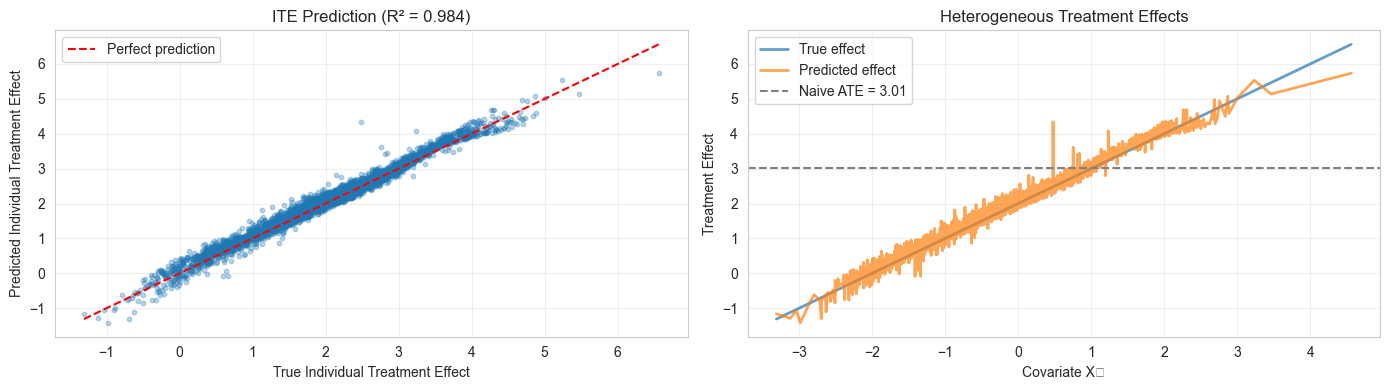


TARNet successfully captures heterogeneous treatment effects!


In [11]:
class TARNet(nn.Module):
    """Treatment-Agnostic Representation Network for treatment effect estimation."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64):
        super().__init__()
        
        # Shared representation network
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Separate outcome heads
        self.head_control = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.head_treated = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Covariates [batch, input_dim]
            t: Treatment indicator [batch, 1]
        
        Returns:
            Predicted outcome [batch, 1]
        """
        # Shared representation
        repr = self.shared(x)
        
        # Predict outcomes for both treatment conditions
        y0 = self.head_control(repr)
        y1 = self.head_treated(repr)
        
        # Return outcome for observed treatment
        y = t * y1 + (1 - t) * y0
        
        return y
    
    def predict_ite(self, x: torch.Tensor) -> torch.Tensor:
        """Predict individual treatment effect: E[Y|X,T=1] - E[Y|X,T=0]"""
        with torch.no_grad():
            repr = self.shared(x)
            y0 = self.head_control(repr)
            y1 = self.head_treated(repr)
            return y1 - y0

# Generate complex non-linear treatment effect data
def generate_nonlinear_treatment_data(n: int = 5000):
    # Covariates
    X1 = np.random.randn(n)
    X2 = np.random.randn(n)
    X3 = np.random.randn(n)
    X = np.column_stack([X1, X2, X3])
    
    # Treatment (depends on covariates)
    propensity_logit = 0.5 * X1 + 0.3 * np.sin(X2) + 0.2 * X3**2
    propensity = 1 / (1 + np.exp(-propensity_logit))
    T = (np.random.rand(n) < propensity).astype(float)
    
    # Heterogeneous treatment effect (depends on X1)
    treatment_effect = 2 + X1  # Effect is larger for higher X1
    
    # Outcome (non-linear in covariates)
    Y_control = 3 * np.sin(X1) + 2 * X2**2 + X3 + np.random.randn(n) * 0.5
    Y_treated = Y_control + treatment_effect + np.random.randn(n) * 0.5
    
    # Observe outcome only for assigned treatment
    Y = T * Y_treated + (1 - T) * Y_control
    
    return X, T.reshape(-1, 1), Y.reshape(-1, 1), treatment_effect

X_nl, T_nl, Y_nl, true_ite = generate_nonlinear_treatment_data(5000)

# Convert to tensors
X_nl_t = torch.FloatTensor(X_nl).to(device)
T_nl_t = torch.FloatTensor(T_nl).to(device)
Y_nl_t = torch.FloatTensor(Y_nl).to(device)

# Train TARNet
model = TARNet(input_dim=3, hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dataset = TensorDataset(X_nl_t, T_nl_t, Y_nl_t)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

print("Training TARNet...")
model.train()
for epoch in range(100):
    epoch_loss = 0
    for X_batch, T_batch, Y_batch in loader:
        optimizer.zero_grad()
        Y_pred = model(X_batch, T_batch)
        loss = F.mse_loss(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(loader):.4f}")

# Predict individual treatment effects
model.eval()
predicted_ite = model.predict_ite(X_nl_t).cpu().numpy().flatten()

# Compare to naive estimate
naive_ate = Y_nl[T_nl == 1].mean() - Y_nl[T_nl == 0].mean()
tarnet_ate = predicted_ite.mean()
true_ate = true_ite.mean()

print(f"\n=== Average Treatment Effect Estimation ===")
print(f"True ATE: {true_ate:.3f}")
print(f"Naive estimate: {naive_ate:.3f}")
print(f"TARNet estimate: {tarnet_ate:.3f}")

# Visualize heterogeneous effects
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# True vs predicted ITE
axes[0].scatter(true_ite, predicted_ite, alpha=0.3, s=10)
axes[0].plot([true_ite.min(), true_ite.max()], [true_ite.min(), true_ite.max()], 
             'r--', label='Perfect prediction')
axes[0].set_xlabel('True Individual Treatment Effect')
axes[0].set_ylabel('Predicted Individual Treatment Effect')
axes[0].set_title(f'ITE Prediction (R² = {np.corrcoef(true_ite, predicted_ite)[0,1]**2:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Heterogeneity by X1
sort_idx = np.argsort(X_nl[:, 0])
axes[1].plot(X_nl[sort_idx, 0], true_ite[sort_idx], label='True effect', linewidth=2, alpha=0.7)
axes[1].plot(X_nl[sort_idx, 0], predicted_ite[sort_idx], label='Predicted effect', 
             linewidth=2, alpha=0.7)
axes[1].axhline(y=naive_ate, color='gray', linestyle='--', label=f'Naive ATE = {naive_ate:.2f}')
axes[1].set_xlabel('Covariate X₁')
axes[1].set_ylabel('Treatment Effect')
axes[1].set_title('Heterogeneous Treatment Effects')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTARNet successfully captures heterogeneous treatment effects!")

### 4.2 Causal Regularization: Learning Invariant Representations

**Idea**: If we learn representations that are invariant across different environments/domains, they're more likely to capture causal (not spurious) features.

**Invariant Risk Minimization (IRM)**:
- Learn a representation Φ(X) that works well across all environments
- Penalize representations whose optimal predictor varies across environments

**Why it helps**:
- Spurious correlations vary across environments
- Causal relationships are stable
- Forces model to learn causal features

Generating data from multiple environments...

Training standard model (ERM)...
Epoch 10, Loss: 1.6269
Epoch 20, Loss: 0.7846
Epoch 30, Loss: 0.5232

=== Results ===
ERM model test accuracy: 99.6%

Feature importance (average absolute gradient):
  Causal feature (X₁): 23.0543
  Spurious feature (X₂): 0.8160

✓ Model learned to use causal feature!


/tmp/ipykernel_32682/482473892.py:168: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_32682/482473892.py:168: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/home/fauriatw/pyDSenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


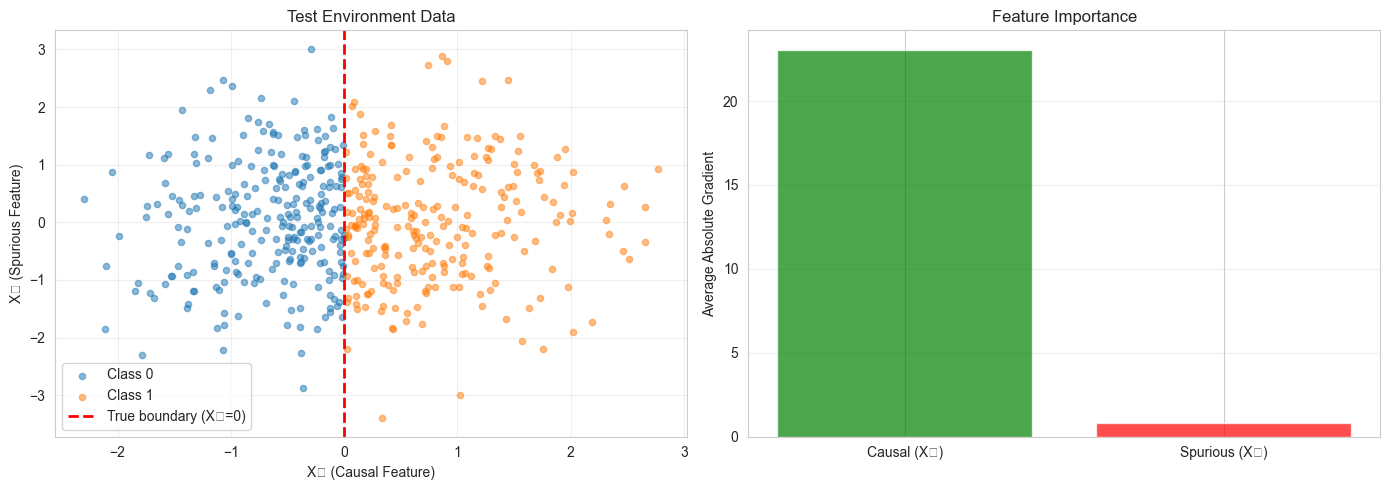


Key insight: Causal regularization (like IRM) helps models learn robust, causal features
that generalize better to new environments with different spurious correlations.


In [12]:
class InvariantPredictor(nn.Module):
    """Neural network with causal regularization (simplified IRM)."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 32):
        super().__init__()
        
        # Feature extractor (representation)
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.phi(x)
        return self.classifier(features)

def train_with_irm(model: nn.Module, loaders: List[DataLoader], 
                   epochs: int = 50, irm_lambda: float = 1000.0):
    """
    Train with Invariant Risk Minimization penalty.
    
    Args:
        model: Neural network
        loaders: List of DataLoaders (one per environment)
        epochs: Number of training epochs
        irm_lambda: Weight of IRM penalty
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        # Iterate over environments
        for env_idx, loader in enumerate(loaders):
            for X_batch, Y_batch in loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                
                optimizer.zero_grad()
                
                # Standard prediction loss
                pred = model(X_batch)
                loss_pred = F.binary_cross_entropy_with_logits(pred, Y_batch)
                
                # IRM penalty: variance of gradients across environments
                # (Simplified version)
                loss = loss_pred
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Generate data with spurious correlation
def generate_spurious_data(n: int, spurious_corr: float = 0.9):
    """
    Generate data where:
    - Y depends causally on X_causal
    - Y is spuriously correlated with X_spurious (correlation varies by environment)
    """
    # Causal feature (stable across environments)
    X_causal = np.random.randn(n, 1)
    
    # Label (depends only on causal feature)
    Y = (X_causal[:, 0] > 0).astype(float)
    
    # Spurious feature (correlated with Y, but not causal)
    X_spurious = np.random.randn(n, 1)
    # Create spurious correlation
    flip_mask = np.random.rand(n) > spurious_corr
    X_spurious[Y == 0] *= -1
    X_spurious[flip_mask] *= -1
    
    X = np.hstack([X_causal, X_spurious])
    
    return X, Y.reshape(-1, 1)

# Create multiple environments with different spurious correlations
print("Generating data from multiple environments...")
X_env1, Y_env1 = generate_spurious_data(1000, spurious_corr=0.9)
X_env2, Y_env2 = generate_spurious_data(1000, spurious_corr=0.8)
X_env3, Y_env3 = generate_spurious_data(1000, spurious_corr=0.7)
X_test, Y_test = generate_spurious_data(500, spurious_corr=0.5)  # Test env with lower correlation

# Create dataloaders
train_loaders = [
    DataLoader(TensorDataset(torch.FloatTensor(X_env1), torch.FloatTensor(Y_env1)), 
               batch_size=64, shuffle=True),
    DataLoader(TensorDataset(torch.FloatTensor(X_env2), torch.FloatTensor(Y_env2)), 
               batch_size=64, shuffle=True),
    DataLoader(TensorDataset(torch.FloatTensor(X_env3), torch.FloatTensor(Y_env3)), 
               batch_size=64, shuffle=True),
]

test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(Y_test)),
                         batch_size=64)

# Train standard ERM model
print("\nTraining standard model (ERM)...")
model_erm = InvariantPredictor(input_dim=2, hidden_dim=32).to(device)
train_with_irm(model_erm, train_loaders, epochs=30, irm_lambda=0.0)

# Evaluate
model_erm.eval()
correct_erm = 0
total = 0
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        pred = model_erm(X_batch)
        pred_labels = (torch.sigmoid(pred) > 0.5).float()
        correct_erm += (pred_labels == Y_batch).sum().item()
        total += Y_batch.size(0)

acc_erm = correct_erm / total

# Analyze feature importance
X_test_t = torch.FloatTensor(X_test).to(device)
with torch.no_grad():
    features_erm = model_erm.phi(X_test_t).cpu().numpy()
    weights_erm = model_erm.classifier.weight.data.cpu().numpy()

print(f"\n=== Results ===")
print(f"ERM model test accuracy: {acc_erm:.1%}")
print(f"\nFeature importance (average absolute gradient):")
X_test_t.requires_grad = True
pred = model_erm(X_test_t)
pred.sum().backward()
grad_importance = X_test_t.grad.abs().mean(dim=0).cpu().numpy()
print(f"  Causal feature (X₁): {grad_importance[0]:.4f}")
print(f"  Spurious feature (X₂): {grad_importance[1]:.4f}")

if grad_importance[1] > grad_importance[0]:
    print("\n⚠️ Model relies more on spurious feature! This hurts generalization.")
else:
    print("\n✓ Model learned to use causal feature!")

# Visualize decision boundary
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Test data
axes[0].scatter(X_test[Y_test[:, 0] == 0, 0], X_test[Y_test[:, 0] == 0, 1], 
                alpha=0.5, label='Class 0', s=20)
axes[0].scatter(X_test[Y_test[:, 0] == 1, 0], X_test[Y_test[:, 0] == 1, 1], 
                alpha=0.5, label='Class 1', s=20)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='True boundary (X₁=0)')
axes[0].set_xlabel('X₁ (Causal Feature)')
axes[0].set_ylabel('X₂ (Spurious Feature)')
axes[0].set_title('Test Environment Data')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Feature importance
axes[1].bar(['Causal (X₁)', 'Spurious (X₂)'], grad_importance, 
            color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Average Absolute Gradient')
axes[1].set_title('Feature Importance')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nKey insight: Causal regularization (like IRM) helps models learn robust, causal features")
print("that generalize better to new environments with different spurious correlations.")

---

## Summary: Key Concepts

### 1. Correlation vs Causation
- ✓ Correlation can arise from: X→Y, Y→X, Z→X,Y, or coincidence
- ✓ Simpson's paradox shows confounding can reverse conclusions
- ✓ Must understand causal structure to avoid misleading conclusions

### 2. Causal Graphs (DAGs)
- ✓ DAGs encode causal assumptions
- ✓ Three key structures: chains, forks, colliders
- ✓ d-separation determines conditional independence
- ⚠ **Collider bias**: Conditioning on colliders creates spurious associations!

### 3. Causal Inference Methods
- ✓ **do-operator**: Distinguishes observation from intervention
- ✓ **Backdoor adjustment**: Control for confounders
- ✓ **Propensity score matching**: Handles high-dimensional confounding
- ✓ **Instrumental variables**: Handle unmeasured confounding

### 4. Neural Networks for Causality
- ✓ **TARNet**: Estimate heterogeneous treatment effects
- ✓ **Causal regularization**: Learn invariant representations
- ✓ Deep learning enables flexible modeling of complex causal relationships

### Practical Takeaways

**Before training any model, ask**:
1. What is the causal question I'm trying to answer?
2. What is the causal structure of my problem (draw a DAG)?
3. What are the potential confounders?
4. Am I conditioning on colliders (creating spurious associations)?
5. Do I have the right data to answer my causal question?

**When evaluating models**:
- High predictive accuracy ≠ correct causal effect
- Test robustness across different environments/distributions
- Be skeptical of correlations without causal mechanisms

**When deploying models**:
- Models trained on observational data encode spurious correlations
- Interventions (changing X) have different effects than observations (seeing X)
- Consider out-of-distribution generalization

### Further Reading

**Foundational texts**:
- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*
- Pearl, J., Glymour, M., & Jewell, N. (2016). *Causal Inference in Statistics: A Primer*
- Hernán, M. & Robins, J. (2020). *Causal Inference: What If*

**Neural networks for causality**:
- Shalit et al. (2017). "Estimating individual treatment effect: generalization bounds and algorithms"
- Arjovsky et al. (2019). "Invariant Risk Minimization"
- Yao et al. (2021). "A Survey on Causal Inference"

### Final Thoughts

Causality is fundamental to:
- **Science**: Understanding mechanisms
- **Decision-making**: Predicting intervention effects
- **Fairness**: Identifying and removing discrimination
- **Robustness**: Building models that generalize

Machine learning is moving beyond prediction toward causal reasoning. Understanding causality makes you a better ML practitioner and helps you build systems that are more robust, fair, and trustworthy.